# Поиск каверов композиций
<br>Разработка ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам

<br>**Описание проекта**
<br>Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей.
<br>Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков.
<br>Например:
- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

<br>**Цель проекта**
<br>Необходимо разработать ML-продукт, который:
- классифицирует треки по признаку кавер-некавер;
- связывает (группирует) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

<br>**Описание данных**
- Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:
    - track_id - уникальный идентификатор трека;
    - track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
    - original_track_id - уникальный идентификатор исходного трека.
- Метаинформация:
    - track_id - уникальный идентификатор трека;
    - dttm - первая дата появления информации о треке;
    - title - название трека;
    - language - язык исполнения;
    - isrc - международный уникальный идентификатор трека;
    - genres - жанры;
    - duration - длительность трека.
- Текст песен:
    - track_id - уникальный идентификатор трека;
    - lyricId - уникальный идентификатор текста;
    - text - текст трека.

<br>**Целевые метрики**

1. `ROC-AUC` (Receiver Operating Characteristic - Area Under the Curve) является метрикой,
   <br>которая оценивает качество бинарной классификации, учитывая полноту (True Positive Rate) и
   <br>специфичность (True Negative Rate) модели.
   <br>ROC-AUC измеряет способность модели различать между классами и представляет площадь под кривой ROC.
   <br>ROC-AUC особенно полезна, когда важно контролировать баланс между ложно-положительными и ложно-отрицательными предсказаниями.
   <br>Она также устойчива к несбалансированным классам.
3. `F1`-мера является метрикой, которая оценивает точность и полноту модели для бинарной классификации.
   <br>F1-мера является гармоническим средним между точностью (precision) и полнотой (recall).
   <br>Она особенно полезна, когда важно достичь баланса между точностью и полнотой.
   <br>F1-мера хорошо работает, когда классы сбалансированы или когда важно минимизировать как ложно-положительные, так и ложно-отрицательные предсказания.

**План выполнения**
1. Загрузка данных и первичное знакомство с ними;
2. Объединение датафреймов для построения baseline;
3. Кодирование данных для baseline;
4. Получение baseline предсказаний;
5. Дополнение данных признаками:
   - кластеризация;
   - обогащение дополнительными данными из внешних источников;
6. Кодирование дополненных данных;
7. Формирование обучающей и тестовой выборок;
8. Обучение моделей трёх различных структур;
9. Получение предсказаний на кросс-валидации;
10. Подбор гиперпараметров;
11. Выбор лучшей модели;
12. Проверка модели на отложенной выборке;
13. Составление отчёта о проделанной работе.

## Настройка рабочей среды

In [67]:
# !pip install seaborn
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install sentence_transformers

In [59]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

try:
    import mlflow
    import psycopg2 as psycopg
    from dotenv import load_dotenv
except:
    import sys
    from google.colab import drive
    from google.colab import userdata




# import transformers
# import numpy as np
# import warnings
# import xgboost
# import csv
# from sklearn.model_selection import train_test_split, cross_validate
# from sklearn.metrics import roc_curve, roc_auc_score, f1_score
# from sklearn.linear_model import LogisticRegression
# from catboost import CatBoostClassifier
# from sklearn.cluster import DBSCAN
# from tqdm import notebook
# from sklearn.model_selection import GridSearchCV

Установка констант

In [58]:
try:
    load_dotenv()
    connection = {"sslmode": "require",
                  "target_session_attrs": "read-write"}
    postgres_credentials = {"host": os.getenv("DB_HOST"),
                            "port": os.getenv("DB_PORT"),
                            "dbname": os.getenv("DB_NAME"),
                            "user": os.getenv("DB_USERNAME"),
                            "password": os.getenv("DB_PASSWORD")}
    TRACKING_SERVER_HOST = "127.0.0.1"
    TRACKING_SERVER_PORT = 5000
    EXPERIMENT_NAME = 'text_covers'
    RUN_NAME = ['baseline_0_registry', 'logreg_0_registry', 'catboost_0_registry']
    REGISTRY_MODEL_NAME = ['baseline', 'logistic_regression', 'catboost']
    ASSETS_DIR = 'assets/'
    COVERS_PATH = 'data/music_covers.json'
    LYRICS_PATH = 'data/music_lyrics.json'
    META_DATA_PATH = 'data/music_meta.json'
except:
    drive.mount('/content/drive')
    COVERS_PATH = userdata.get('covers')
    LYRICS_PATH = userdata.get('lyrics')
    META_DATA_PATH = userdata.get('meta')

BATCH_SIZE = 100
RANDOM_STATE = 42
MAX_TOKEN_LEN = 512

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
# torch.manual_seed(RANDOM_STATE)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(RANDOM_STATE)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Импорт класса для проведения исследоваия

In [3]:
try:
    from research_class import DatasetExplorer
except:
    from google.colab import userdata
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(userdata.get('my_module'))
    import research_class
    research_class.DatasetExplorer

## Загрузка данных

In [4]:
covers = pd.read_json(COVERS_PATH, orient='records', lines=True)
lyrics = pd.read_json(LYRICS_PATH, orient='records', lines=True)
meta = pd.read_json(META_DATA_PATH, orient='records', lines=True)

np.array(covers).shape, np.array(lyrics).shape, np.array(meta).shape

((71597, 3), (11414, 3), (71769, 7))

### lyrics

In [5]:
explorer_lyrics = DatasetExplorer(lyrics, target=None)

In [6]:
explorer_lyrics.explore_dataset(assets_dir=None, list_column=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
5908,c417dcedbdb1278d987567fd99f2b31d,У неё на запястье cartie\nВ её бокале bacardi\...,c33f73686c3e6fbe81722e4bd9ceceeb
8949,83128615c4850f2398620440436d1371,Как тебя взять и забыть\nНе встречать тебя вез...,0388be82e560291ab1b3a96a24b6a24d
5665,e143954e84e0e203a3834a2510596548,Mandó Jesús el gran Consolador\nÉl vino con su...,49da7e09a60d43cf88873a6438de9194
3538,33b340743ddafd189d287e1ccc5e3e6a,Come on\nCome on\nCome on\nCome on\nDidn't I m...,544d8a7bb8401b0c7450ed9d6950a1fc
6248,8ab43eb4ac2d8cbad53da17bd9fc794b,"She thinks she missed the train to Mars, she's...",281a1dc64294e48c2b884c3d194ff51d


количество полных дубликатов строк: 0
количество пропущенных значений:
lyricId     0
text        0
track_id    0
dtype: int64
Количество уникальных значений в столбце 'lyricId': 10915
Соотношение уникальных значений и общего количества записей в столбце 'lyricId': 0.96

Количество уникальных значений в столбце 'track_id': 10277
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 0.90



#### Выводы:
- тексты представлены на различных языках (английский, русский, испанский и др.);
- явных повторов строк не обнаружено, при этом количество уникальных ID текстов и треков меньше;
  <br>чем всего строк, что означает использование текстов в других треках;
- пропущенных значений в данных не обнаружено

### meta

In [7]:
explorer_meta = DatasetExplorer(meta, target=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
40169,c0840baaf23114d079939d40d9be37a8,1.672952e+12,Sweet Disposition,EN,USM952300001,"[ROCK, ALLROCK]",234670.0
68734,7c29472522f674da8fe8fb7a5b6b31c1,1.549411e+12,Sunflower,EN,FR10S1938030,[POP],155810.0
33349,22296461d41d5795ef6d4ee0141e51f0,1.644786e+12,Bajo La Luz de la Luna,ES,QZDFP1937971,"[ROCK, ALLROCK]",211750.0
47549,e5f9f58131e23ee65c947e5fdbc81647,1.359922e+12,Demons,EN,USUM71201071,"[ALTERNATIVE, ROCK, ALLROCK]",177500.0
24617,45bf1523b6b064ac3ccdd157c2ee2af2,1.623426e+12,Shape Of You,EN,QZGWX2211972,"[POP, DANCE]",161950.0


количество полных дубликатов строк: 0
количество пропущенных значений:
track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          0
duration        1
dtype: int64


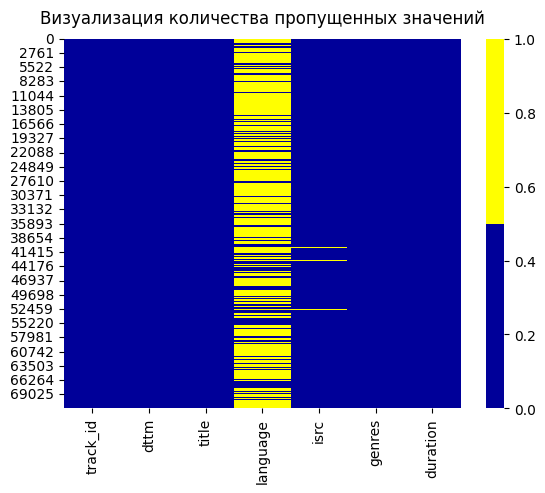

Процент пропущенных значений в признаках:
track_id: 0.00%
dttm: 0.00%
title: 0.00%
language: 69.39%
isrc: 0.44%
duration: 0.00%
Количество уникальных значений в столбце 'track_id': 71768
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 1.00



In [8]:
explorer_meta.explore_dataset(assets_dir=None, list_column='genres')

In [9]:
print(f"Количество уникальных записей language: {meta['language'].nunique()}")

Количество уникальных записей language: 85


#### Выводы:
- явных повторов строк не обнаружено;
- количество стран в колонке `language` - 85;
- информацию о страннах имеют около 30% записей;
- все `track_id` уникальны;
- даты представлены в unix формате;
- можно удалить признаки:
  - `duration` - не несёт важной информации, т.к. продолжительность кавера может отличаться от исходника
  - `genres` - не несёт важной информации, т.к. жанр кавера может отличаться от исходника
  - `isrc` - не несёт важной информации, т.к. имеется признак `track_id`, а ещё в нём есть пропуски

### covers

In [10]:
explorer_covers = DatasetExplorer(covers, target='track_remake_type')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


,original_track_id,track_id,track_remake_type
33246,None,422081bd5097bc4a16c9239384c126c0,COVER
50497,None,8488a7aa56409274e9046e3144fdca9b,COVER
16456,None,3351b82986bfff3db4103eb5af33ac09,COVER
63244,None,2d43a40e9c72ab1a28834452fb6c070f,COVER
6803,None,6e6ea79639c3dcfd953168084f74622b,COVER


количество полных дубликатов строк: 0
количество пропущенных значений:
original_track_id    66776
track_id                 0
track_remake_type        0
dtype: int64


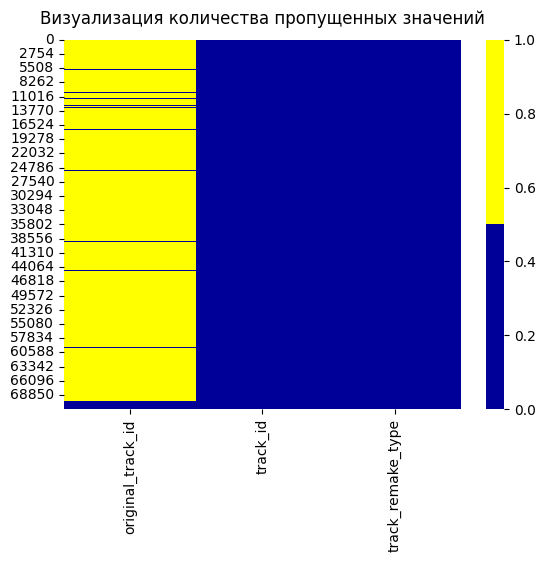

Процент пропущенных значений в признаках:
original_track_id: 93.27%
Количество уникальных значений в столбце 'original_track_id': 4468
Соотношение уникальных значений и общего количества записей в столбце 'original_track_id': 0.06

Количество уникальных значений в столбце 'track_id': 71597
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 1.00

Соотношение классов целевой переменной:
			track_remake_type
ORIGINAL     4293
COVER       67304
Name: count, dtype: int64


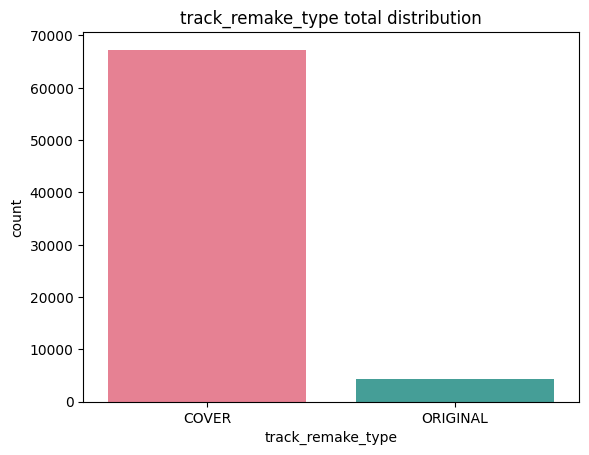

In [12]:
explorer_covers.explore_dataset(assets_dir=None, list_column=None)

In [14]:
print(f"Оригинальных треков указано: {round(covers['original_track_id'].count() / covers['track_id'].count() * 100, 2)}% записей")

Оригинальных треков указано: 6.73% записей


#### Выводы:
- дубликатов строк не обнаружено;
- все `track_id` уникальны;
- классы целевой переменной крайне несбалансированы:
  <br>количество указанных оригинальных треков - 6.73 % от общего числа треков

### Формирование baseline датафрейма

In [27]:
covers_base = covers.copy()
covers_base.dropna(subset='original_track_id', inplace=True)
cover_lyric = (covers_base
               .merge(lyrics, on='track_id', how='left')
               .merge(meta, on='track_id', how='left')
              )

cover_lyric.dropna(subset=['text'], inplace=True)

Формирование списков признаков

In [38]:
ids = [col for col in cover_lyric.columns if 'id' in col.lower()]
ids.append('isrc')
target = ['track_remake_type']
num_features = cover_lyric.select_dtypes(include=['number']).columns
text_features = ['text', 'title']

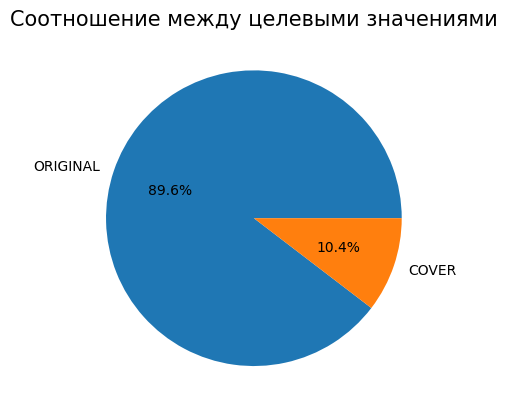

In [54]:
labels = cover_lyric['track_remake_type'].value_counts().index
sizes = [cover_lyric['track_remake_type'].value_counts().iloc[0],
         cover_lyric['track_remake_type'].value_counts().iloc[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Соотношение между целевыми значениями', size=15)
plt.show()

#### Вывод:
- данные объединены;
- удалены пропущенные тексты;
- сформированы списки признаков;
- проверен баланс классов в сформированном датафрейме.

## Подготовка данных для обучения

### baseline_data

In [68]:
# text_sentences = np.array(cover_lyric['text'])
# title_sentences = np.array(cover_lyric['title'])

try:
    title_embeddings = pd.read_csv('data/title_embeddings.csv')
    text_embeddings = pd.read_csv('data/text_embeddings.csv')
except:
    # model = SentenceTransformer('sentence-transformers/LaBSE')  # архитектура LaBSE (Language-agnostic BERT Sentence Embedding) (~ 5 мин)
    # title_embeddings = model.encode(title_sentences)
    # title_embeddings_df = pd.DataFrame(title_embeddings)
    # title_embeddings_df.to_csv('data/title_embeddings.csv', index=False)
    # print("Файл title_embeddings.csv успешно сохранен.")
    text_embeddings = model.encode(text_sentences)
    text_embeddings_df = pd.DataFrame(text_embeddings)
    text_embeddings_df.to_csv('data/text_embeddings.csv', index=False)
    print("Файл text_embeddings.csv успешно сохранен.")
text_embeddings.shape, title_embeddings.shape

KeyboardInterrupt: 

#### Вывод:
- получены эмбеддинги текстов и наименований при помощи библиотеки `sentence_transformer` на архитектуре LaBSE
- выбор данной архитектуры обусловлен её способностью распознавать и сравнивать тексты на более, чем 100 языках
- 

Соединение закодированных текстов с исходными данными

In [12]:
df_work = cover_lyric_wona.copy()
df_work = df_work.join(pd.DataFrame(sentence_embeddings), how='left')
print('полный датасет', df_work.shape)
df_work = df_work.loc[:10999] # ограничение данных до 11000 записей
print('обрезанный датасет', df_work.shape)
df_work.head(3)

полный датасет (11097, 774)
обрезанный датасет (11000, 774)


,original_track_id,track_id,track_remake_type,text,dttm,duration,0,1,2,3,...,758,759,760,761,762,763,764,765,766,767
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,Left a good job in the city\nWorkin' for the m...,1.257973e+12,187220.0,-0.071151,-0.000550,-0.015525,-0.068183,...,0.037262,-0.010959,0.025177,0.026895,0.004867,-0.043662,-0.015377,-0.008442,-0.041558,-0.055484
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,Left a good job in the city\nWorkin' for the m...,1.257973e+12,187220.0,-0.072601,-0.008105,-0.007002,-0.066120,...,0.040421,-0.008107,0.017281,0.025594,0.005750,-0.043891,-0.017041,-0.004621,-0.034674,-0.053124
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,Some folks are born made to wave the flag\nOoh...,1.257973e+12,137780.0,-0.053419,-0.000123,-0.033951,-0.025266,...,-0.007231,0.005841,-0.020928,0.031590,0.011153,-0.046689,0.015612,0.051465,-0.066878,-0.074791


Вывод:
- закодированные тексты присоединены к основному датафрейму

Вывод:
- в данных наблюдается дисбаланс классов
- при разделении на выборки необходимо учесть этот момент

## Machine learning

In [15]:
# данные на эмбеддингах sentencetransformer
df_tr = df_work.copy()
X = df_tr.drop(['original_track_id', 'track_id', 'track_remake_type', 'text'], axis=1)
y = df_tr['track_remake_type']
y = (y != 'ORIGINAL').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RS,
                                                    stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8800, 770), (2200, 770), (8800,), (2200,))

In [ ]:
# данные на эмбеддингах bert transformer
df_tr_b = df_o.copy()
X_bert_em = df_tr_b.drop(['original_track_id', 'track_id', 'track_remake_type'], axis=1)
y_bert_em = df_tr_b['track_remake_type']
y_bert_em = (y_bert_em != 'ORIGINAL').astype(int)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bert_em,
                                                            y_bert_em,
                                                            test_size=0.2,
                                                            random_state=RS,
                                                            stratify=y_bert_em)
X_train_b.shape, X_test_b.shape, y_train_b.shape, y_test_b.shape

((8800, 770), (2200, 770), (8800,), (2200,))

In [16]:
# для кластеризации общие данные
X_train_k = X_train.iloc[:,:2]
X_train_k = (X_train_k
             .merge(df_tr[['original_track_id', 'track_id']], left_index=True, right_index=True, how='left')
             .merge(y_train, left_index=True, right_index=True, how='left'))

Вывод:
- данные поделены на обучающую и тестовую выборки с учётом дисбаланса классов

### Baseline: LogisticRegression + SentenceTransformer

In [56]:
baseline = LogisticRegression(random_state=RS)

lg_scores = (
    cross_validate(baseline, X_train.values, y_train,
                   cv=round((X_train.shape[0] / X_test.shape[0]),),
                   scoring=['f1', 'roc_auc'])
    )

print('Среднее значение F1-меры:', round(lg_scores['test_f1'].mean(), 2))
print('Среднее значение ROC-AUC:', 1 - round(lg_scores['test_roc_auc'].mean(), 2))

Среднее значение F1-меры: 0.83
Среднее значение ROC-AUC: 0.6


Вывод:

- в качестве базовой модели принята `LogisticRegression` на эмбеддингах `SentenceTransformer`
- при её обучении с использованием кросс-валидации получены метрики `ROC-AUC: 0.6`, `F1-мера: 0.83`
- низкое значение ROC-AUC может быть следствием нелинейности данных и дисбаланса классов

### XGBoost на эмбеддингах SentenceTransformer

In [60]:
xgb_st = xgboost.XGBClassifier(random_state=RS)

xgb_st_scores = (
    cross_validate(xgb_st, X_train, y_train,
                   cv=round((X_train.shape[0] / X_test.shape[0]),),
                   scoring=['f1', 'roc_auc'])
    )

print('Среднее значение F1-меры:', round(xgb_st_scores['test_f1'].mean(), 2))
print('Среднее значение ROC-AUC:', round(xgb_st_scores['test_roc_auc'].mean(), 2))

Среднее значение F1-меры: 0.91
Среднее значение ROC-AUC: 0.9


Вывод:
- при обучении `XGBoost` на эмбеддингах `SentenceTransformer`
<br>с использованием кросс-валидации получены метрики `ROC-AUC: 0.9`, `F1-мера: 0.91`
- затраченное на обучение время: ~5 мин.

### XGBoost на эмбеддингах Bert

In [ ]:
# Преобразование данных в формат DMatrix
dtrain_b = xgboost.DMatrix(X_train_b, label=y_train_b)
dtest_b = xgboost.DMatrix(X_test_b, label=y_test_b)

# Обучение модели
xgb_b = xgboost.train(params_xgb, dtrain_b, evals=[(dtest_b, 'Test')], num_boost_round=1000, verbose_eval=100)

# Получение предсказаний на тестовом наборе данных
y_pred_xgb_b = xgb_b.predict(dtest_b)
y_pred_xgb_b_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb_b]

# Вычисление ROC-AUC
auc_xgb_b = roc_auc_score(y_test_b, y_pred_xgb_b)
print('ROC-AUC:', round(auc_xgb_b, 4))

# Вычисление F1-меры
f1_xgb_b = f1_score(y_test_b, y_pred_xgb_b_binary)
print("F1-мера:", round(f1_xgb_b, 4))

[0]	Test-auc:0.77045
[100]	Test-auc:0.91248
[200]	Test-auc:0.91857
[300]	Test-auc:0.92102
[400]	Test-auc:0.92230
[500]	Test-auc:0.92198
[600]	Test-auc:0.92261
[700]	Test-auc:0.92373
[800]	Test-auc:0.92415
[900]	Test-auc:0.92464
[999]	Test-auc:0.92529
ROC-AUC: 0.9253
F1-мера: 0.9197


Вывод:

- при обучении `XGBoost` на эмбеддингах `Bert` получены метрики `ROC-AUC: 0.9253`, `F1-мера: 0.9197` на тестовых данных

### CatBoost на эмбеддингах Bert

In [ ]:
cb_b = CatBoostClassifier(random_state=RS, eval_metric='AUC') # инициализация модели
cb_b.fit(X_train_b, y_train_b, eval_set=(X_test_b, y_test_b), verbose=100, plot=True) # обучение модели

# Вычисление и вывод ROC-AUC
y_pred_proba_cb_b = cb_b.predict_proba(X_test_b)[:, 1]
roc_auc_cb_b = roc_auc_score(y_test_b, y_pred_proba_cb_b)
print("ROC-AUC на тестовой выборке:", roc_auc_cb_b)

# Вычисление F1-меры
y_pred_cb_b = cb_b.predict(X_test_b) # получение предсказаний на тестовой выборке
y_pred_cb_b_binary = [1 if p >= 0.5 else 0 for p in y_pred_cb_b]
f1_cb_b = f1_score(y_test_b, y_pred_cb_b_binary)
print("F1-мера на тестовой выборке:", f1_cb_b)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.054225
0:	test: 0.7647068	best: 0.7647068 (0)	total: 452ms	remaining: 7m 31s
100:	test: 0.9049358	best: 0.9053281 (98)	total: 23.7s	remaining: 3m 31s
200:	test: 0.9156597	best: 0.9157406 (199)	total: 54.1s	remaining: 3m 35s
300:	test: 0.9208705	best: 0.9208705 (300)	total: 1m 27s	remaining: 3m 23s
400:	test: 0.9231766	best: 0.9233485 (396)	total: 1m 58s	remaining: 2m 57s
500:	test: 0.9261925	best: 0.9262046 (499)	total: 2m 26s	remaining: 2m 25s
600:	test: 0.9271681	best: 0.9272409 (598)	total: 2m 49s	remaining: 1m 52s
700:	test: 0.9279112	best: 0.9279112 (700)	total: 3m 10s	remaining: 1m 21s
800:	test: 0.9283642	best: 0.9287413 (792)	total: 3m 34s	remaining: 53.4s
900:	test: 0.9290244	best: 0.9291518 (897)	total: 3m 56s	remaining: 26s
999:	test: 0.9301041	best: 0.9301041 (999)	total: 4m 19s	remaining: 0us

bestTest = 0.9301041351
bestIteration = 999

ROC-AUC на тестовой выборке: 0.930104135072288
F1-мера на тестовой выборке: 0.9219467401285584


Вывод:
- при обучении `CatBoost` на эмбеддингах `Bert` получены метрики `ROC-AUC: 0.93`, `F1-мера: 0.92` на тестовых данных

### CatBoost на эмбеддингах SentenceTransformer

In [73]:
cb_st = CatBoostClassifier(random_state=RS, eval_metric='AUC', verbose=100)

cb_st_scores = (
    cross_validate(cb_st, X_train, y_train,
                   cv=round((X_train.shape[0] / X_test.shape[0]),),
                   scoring=['f1', 'roc_auc'])
    )

print('Среднее значение F1-меры:', round(cb_st_scores['test_f1'].mean(), 2))
print('Среднее значение ROC-AUC:', round(cb_st_scores['test_roc_auc'].mean(), 2))

Learning rate set to 0.023061
0:	total: 476ms	remaining: 7m 55s
100:	total: 25.8s	remaining: 3m 49s
200:	total: 47.8s	remaining: 3m 10s
300:	total: 1m 23s	remaining: 3m 13s
400:	total: 1m 46s	remaining: 2m 39s
500:	total: 2m 7s	remaining: 2m 6s
600:	total: 2m 27s	remaining: 1m 38s
700:	total: 2m 50s	remaining: 1m 12s
800:	total: 3m 12s	remaining: 47.8s
900:	total: 3m 34s	remaining: 23.6s
999:	total: 3m 55s	remaining: 0us
Learning rate set to 0.023061
0:	total: 250ms	remaining: 4m 9s
100:	total: 21.3s	remaining: 3m 9s
200:	total: 49s	remaining: 3m 14s
300:	total: 1m 9s	remaining: 2m 42s
400:	total: 1m 30s	remaining: 2m 15s
500:	total: 1m 51s	remaining: 1m 50s
600:	total: 2m 13s	remaining: 1m 28s
700:	total: 2m 35s	remaining: 1m 6s
800:	total: 2m 56s	remaining: 43.9s
900:	total: 3m 17s	remaining: 21.7s
999:	total: 3m 38s	remaining: 0us
Learning rate set to 0.023061
0:	total: 379ms	remaining: 6m 18s
100:	total: 23.4s	remaining: 3m 28s
200:	total: 45.2s	remaining: 2m 59s
300:	total: 1m 6s	

Вывод:

- при обучении `CatBoost` на эмбеддингах `SentenceTransformer`
<br>с использованием кросс-валидации получены метрики `ROC-AUC: 0.9`, `F1-мера: 0.91`
- затраченное на обучение время: ~15 мин.

### Сводные данные

In [74]:
dict2 = {#'Catboost + Bert Transformer': [f1_cb_b, roc_auc_cb_b],
         #'XGBoost + Bert Transformer': [f1_xgb_b, auc_xgb_b],
         'Catboost + SentenceTransformer': [cb_st_scores['test_f1'].mean(),
                                           cb_st_scores['test_roc_auc'].mean()],
         'XGBoost + SentenceTransformer': [xgb_st_scores['test_f1'].mean(),
                                           xgb_st_scores['test_roc_auc'].mean()],
         'Baseline': [lg_scores['test_f1'].mean(),
                                                      1 - lg_scores['test_roc_auc'].mean()]}
summary_data = (pd.DataFrame.from_dict(dict2, orient='index',
                                      columns=["F1", "ROC-AUC"]).reset_index()
                                      .rename(columns={'index': 'model'})
                                      )
summary_data.sort_values(by=['ROC-AUC'], ascending=False, inplace=True)
summary_data

,model,F1,ROC-AUC
0,Catboost + SentenceTransformer,0.905161,0.904709
1,XGBoost + SentenceTransformer,0.906288,0.901893
2,Baseline,0.832969,0.602723


## Кластеризация DBSCAN

Данные для кластеризации

In [ ]:
df_kl=X_train_k.copy()
feature_o = X_train

Обучение модели

In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=2)
dbscan.fit(feature_o.values)
labels = dbscan.labels_
df_kl['labels'] = labels

Поиск трека в кластере с наиболее ранней датой

In [ ]:
min_date_rows = df_kl.groupby('labels')['dttm'].idxmin()
earliest_dates = df_kl.loc[min_date_rows]

Добавление метки оригинала

In [ ]:
earliest_dates['target_labels'] = '0 ORIGINAL'
earliest_dates['or_tr_ID'] = earliest_dates['track_id']
dict_or = dict(zip(earliest_dates['labels'], earliest_dates['or_tr_ID'])) # создание словаря

Добавление информации к  исходным данным

In [ ]:
# объединим таблицы
df_kl = df_kl.merge(earliest_dates[['target_labels', 'or_tr_ID']], left_index=True, right_index=True, how='left')
# заполним столбец ID оригинального трека
df_kl['or_tr_ID'] = df_kl['labels'].map(dict_or)
# укажем каверы
df_kl['target_labels'].fillna('1 COVER', inplace=True)
# определение треков не вошедших в кластеры
df_kl.loc[df_kl['labels'] == -1, ['target_labels', 'or_tr_ID']]  = '-'
df_kl = df_kl.drop(['dttm', 'duration'], axis=1) # удалим ненужную информацию
'кластеры и количество треков в них:', df_kl['labels'].value_counts()

('кластеры и количество треков в них:',
 -1       4607
  20        98
  99        74
  28        57
  57        53
          ... 
  540        2
  541        2
  542        2
  544        2
  1125       2
 Name: labels, Length: 1127, dtype: int64)

Проверка полученных кластеров

In [ ]:
# полученные кластеры
df_kl[df_kl['labels'] >= 0].sort_values(by='labels').sample(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
7571,None,d5e73a91b22b6473bef6464611330b22,1,85,1 COVER,ecfcc3542d9219bf01cd5fdf92821b79
7504,329703a0b71ba0c8321eb01e0c5eb74f,329703a0b71ba0c8321eb01e0c5eb74f,0,129,1 COVER,09e816e3c7072f3b6f6884ad63606506
8712,None,55639effa3681e6605b12b43b81268c6,1,141,1 COVER,48e62100d29c5e528739f3e1d60daa94
356,None,2e0b4d97f2019d8271aad70e6e9cbe8a,1,672,1 COVER,2e0b4d97f2019d8271aad70e6e9cbe8a
6681,None,6bf71d6456063735e930c2e0b440bf4d,1,411,1 COVER,458ba5e50926d890a541c0fd4ebc2863


In [ ]:
df_kl[df_kl['target_labels'] != '-'].sample(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
3500,None,c126ad9de2b3278e4cd6c04e91519405,1,719,1 COVER,930531da8e07084f9d7bf45067be8c53
2853,b394cdc3b1e3b509207b2082215023ac,b394cdc3b1e3b509207b2082215023ac,0,257,1 COVER,53e9ba631b769af52861834d8559a797
5587,None,201bc33d8583d71c4450e707d4bedced,1,386,1 COVER,78a576e7be283c8fe40a1d25761cec0a
6798,ba69d68ec0eb38289828ce00658c4474,ba69d68ec0eb38289828ce00658c4474,0,717,1 COVER,ab329a713d3b872a974c99a3d95f2f5c
7912,4bff13b29d32b21fe548d4751f6217c4,4bff13b29d32b21fe548d4751f6217c4,0,195,1 COVER,933915d7cfd8d406f6c3b457291fa1be


In [ ]:
# количество правильно определенных original_track_id	(8,6%) в общей численности - 8800
(df_kl['original_track_id'] == df_kl['or_tr_ID']).value_counts()

False    8047
True      753
dtype: int64

In [ ]:
orig = df_kl[df_kl['original_track_id'].notnull()]
orig.head(5)

,original_track_id,track_id,track_remake_type,labels,target_labels,or_tr_ID
9772,1b20046d1401fad20997960f00c2e2b2,1b20046d1401fad20997960f00c2e2b2,0,-1,-,-
9760,10c31ae14820dabb1205f8cf646360b4,10c31ae14820dabb1205f8cf646360b4,0,-1,-,-
1522,951edd96627f47b783716a54d2368d7b,951edd96627f47b783716a54d2368d7b,0,3,0 ORIGINAL,951edd96627f47b783716a54d2368d7b
4220,a76ea1ec728632135e72fc76c27a7fa9,a76ea1ec728632135e72fc76c27a7fa9,0,-1,-,-
7663,e3dc2ec24a07c8de52051cea81f2797c,e3dc2ec24a07c8de52051cea81f2797c,0,-1,-,-


In [ ]:
# количество правильно определенных original_track_id	(26,7%) в численности original_track_id - 2822
(orig['original_track_id'] == orig['or_tr_ID']).value_counts()

False    2069
True      753
dtype: int64

Для лучших результатов следует попробовать поменять параметры кластеризаци: eps - радиус окрестности для определения плотности  min_samples - минимальное количество соседей (сейчас эти значения (0.3, 2))

Вывод:
- для кластеризации данных применена библиотека DBSCAN
- положительных результатов пока не удалось добиться

## Заключение:
- в решении поставленной задачи основными признаками приняты текст и дата появления трека
- целевой метрикой выбрана roc-auc, т.к. она устойчива к дисбалансу классов, который присущ предоставленным данным
- при кодировании текстов использованы два трансформера: SentenceTransformer, Bert transformer
- для обучения использовались признаки: дата выхода трека, эмбеддинги
- целевой признак - метка оригинал/кавер
- удалённые признаки:
  - ID треков и текстов (чтобы модель была более универсальной)
  - текст - удалён, т.к. есть его эмбеддинги
  - язык, продолжительность, жанр - удалены, т.к. сами по себе данные признаки не информативны для решения поставленной задачи
- при обучении выбирали лучшую из моделей: XGBoost, CatBoost, LogisticRegression
- наилучший результат по выбранной метрике показала модель: CatBoost на эмбеддингах, полученных через Bert Transformer
- не реализованные идеи:
  - пробовали использовать библиотеку MusicMetaLinker для обогащения предоставленных данных, но для полноценного использования не хватило отведённого времени
  - рассматривали алгоритм Doc2Vec, для полноценного изучения не хватило времени
  - кластеризация данных библиотекой DBScan, для полноценного изучения не хватило времени